In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})
import scipy.interpolate

# Metode  1 - fra den første artikel

ligninger 

for $\delta_{cdm}$

$\dot{\delta}_{cdm} = - \theta_{cdm}$

$\dot{\theta}_{cdm} = - \mathcal{H}a\theta_{cdm} - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a} \delta_{cdm}$

baseret på https://arxiv.org/abs/1602.05933 med e ekstra faktor a på $\mathcal{H}$ i $\dot{\theta}_{cdm}$

ved neutrinoer er $\dot{\delta}$ den samme.

$\dot{\theta}_{\nu}   =  -\mathcal{H}a\theta_{\nu} - \frac{3}{2}\frac{H_0 ^2 \Omega_M}{a} \delta_{cdm} + k^2  cs^2 \delta_{\nu}$


In [2]:
kvec = [1e-1,1,1e1]
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
mv_test = 0.3 
H0 = 67 / (3*1e5) # i 1/Mpc

cosmo_dict ={'H0':70,  'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }

cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()

pts = cosmo.get_perturbations()['scalar']
print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]

mv = mv_test * 1e-6

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [37]:
x = 200
k_ind = -1
k = kvec[k_ind]
T_ini = x / k
# cs front faktoren
factor = 1.2#0.7#2.68


# udregner Hubbleparameteren

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

# udregnger tau 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

# temperatur

def Tv(a):
    return T0 / a # in MeV

# lydhastighed

def cs(a,mv,factor):
    return factor * Tv(a) / mv

# udregn a
def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]

tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
tau = sol_tau.y[0]

sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
a_tau = sol_a.t
a = sol_a.y[0]

a_interp = scipy.interpolate.interp1d(a_tau,a)

# sammenlignings data fra Class

delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)

delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]

a_class = pts[k_ind]["a"]

delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)


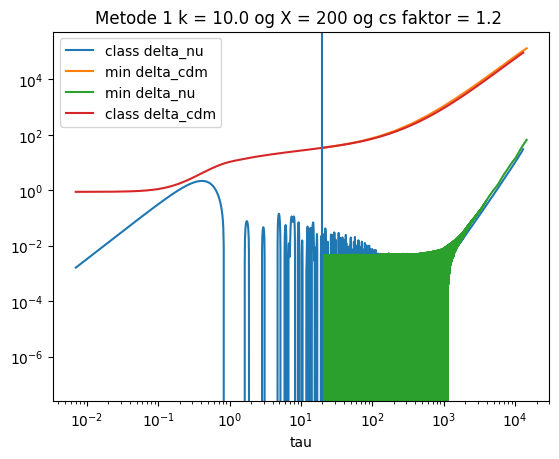

In [42]:
t_span = [T_ini,tau[-1]]


def cdm_func1(τ,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(τ)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   =  - nabla2phi-  H(a) * theta * a
    return [d_delta,d_theta]

y01 = [delta_init,theta_init]

sol_cdm1 = sc.solve_ivp(cdm_func1, t_span = t_span, y0 = y01)

t_cdm1 = sol_cdm1.t
delta_cdm1 = sol_cdm1.y[0]


delta_cdm_interp1 = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func1(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp1(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta 
    return [d_delta,d_theta]


y01_neutrino = [delta_neutrino_init,theta_neutrino_init]

sol_neu1 = sc.solve_ivp(neu_func1, t_span = t_span, y0 = y01_neutrino,args=(k,mv,factor))

t_nue1 = sol_neu1.t
delta_neu1 = sol_neu1.y[0]


plt.loglog(tau_class,-delta_neutrino_class,label="class delta_nu")
plt.loglog(t_cdm1,-delta_cdm1,label="min delta_cdm")
plt.loglog(t_nue1,-delta_neu1,label="min delta_nu")
plt.loglog(tau_class,-delta_class,label="class delta_cdm")

plt.axvline(T_ini)
plt.xlabel("tau")
plt.title("Metode 1 k = %s og X = %s og cs faktor = %s " %(k,x,factor))
plt.legend()

In [8]:
τ = 2
print(τ)

2
